In [2]:
from deepface import DeepFace

import csv
import os
import tqdm
import pickle
from results import get_results

import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

from lime import lime_image
from skimage.segmentation import mark_boundaries

In [92]:
objs = DeepFace.analyze(
    img_path = "C:/Users/Michi/Desktop/Informatik/AI Act/DeepFace/images/2.jpg", 
    actions = ['age', 'gender', 'race', 'emotion'],
    enforce_detection = False
)

print(objs)

Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 85.03it/s]

[{'age': 28, 'region': {'x': 0, 'y': 0, 'w': 223, 'h': 223, 'left_eye': None, 'right_eye': None}, 'face_confidence': 0, 'gender': {'Woman': 5.93448281288147, 'Man': 94.06552314758301}, 'dominant_gender': 'Man', 'race': {'asian': 82.42986097513801, 'indian': 4.139996194243205, 'black': 0.3454034888239794, 'white': 3.0954686907213147, 'middle eastern': 0.24428390025549532, 'latino hispanic': 9.744991197883557}, 'dominant_race': 'asian', 'emotion': {'angry': 7.477584063053655e-05, 'disgust': 4.804314125618925e-13, 'fear': 6.6392331632414425e-06, 'happy': 4.5510269330861775e-06, 'sad': 0.007636885129613802, 'surprise': 4.950447163309946e-07, 'neutral': 99.99227523803711}, 'dominant_emotion': 'neutral'}]


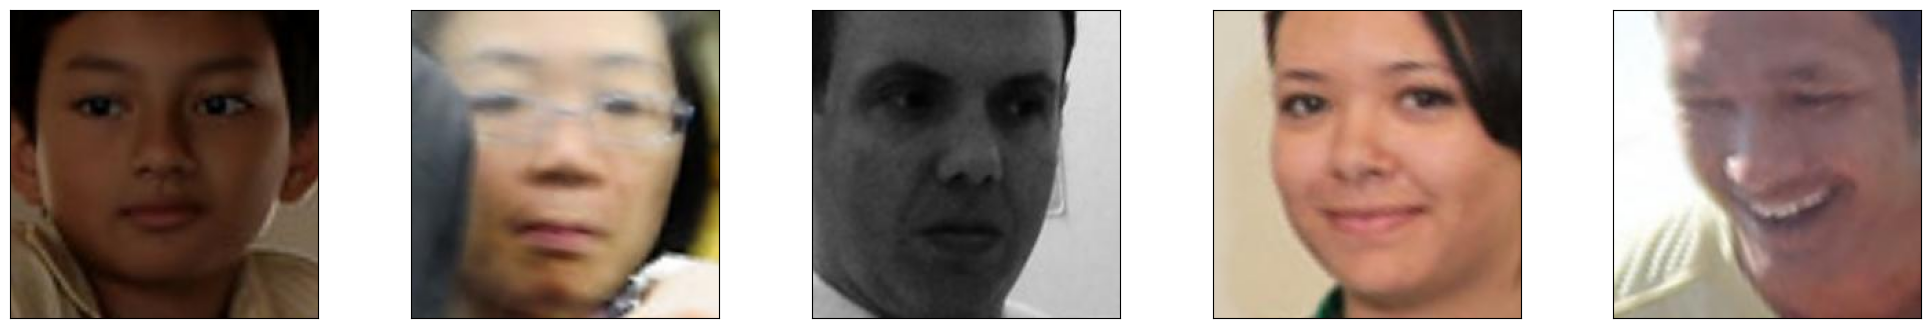

In [99]:
def get_image(path):
    with open(os.path.abspath('C:/Users/Michi/Desktop/Informatik/AI Act/DeepFace/images/' + path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
#get all .jpeg files in the data folder
#images = [get_image(i) for i in os.listdir('C:/Users/Michi/Desktop/Informatik/AI Act/DeepFace/images') if i.endswith('.jpg')]
images = [get_image('{}.jpg'.format(i)) for i in range(1,101)]

# plot the images
fig = plt.figure(figsize=(25, 4))
for idx, img in enumerate(images):
    if idx > 4:
        break
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(img)

In [93]:
idx2label = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

def predict(images):
    probs_batch = []
    if len(images.shape) == 3:
        images = images[None,:] #add empty batch dimension for single image
    nr_img = images.shape[0]
    for i in range(nr_img):
        image = images[i]
        objs = DeepFace.analyze(
            img_path = image,
            actions = ['emotion'],
            enforce_detection = False)
        probs_dict = objs[0]["emotion"]
        probs_distr = [probs_dict["angry"]/100, probs_dict["disgust"]/100, probs_dict["fear"]/100, probs_dict["happy"]/100, probs_dict["sad"]/100, probs_dict["surprise"]/100, probs_dict["neutral"]/100]
        probs_batch.append(probs_distr)   
    return probs_batch

def make_plot(num):
    top_labels = 2
    amt_rows = 1 + top_labels
    ax = plt.subplot(1,3,1)
    plt.axis('off')
    plt.imshow(image)
    ax.title.set_text('input')
    for i in range(top_labels):
        #mask applied to the image
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=10, hide_rest=False)
        img_boundry2 = mark_boundaries(temp/255.0, mask)
        ax = plt.subplot(1, 3, 2+i)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        plt.imshow(img_boundry2)
        ax.title.set_text('{}'.format(idx2label[explanation.top_labels[i]]))
        ax.set(xlabel='Probability: {:.2f}'.format(100*prediction[0][explanation.top_labels[i]]))
    plt.savefig("LIME_results/emotion_" + str(num) + ".png", bbox_inches="tight")

In [105]:
idx2label = ["Woman", "Man"]

def predict(images):
    probs_batch = []
    if len(images.shape) == 3:
        images = images[None,:] #add empty batch dimension for single image
    nr_img = images.shape[0]
    for i in range(nr_img):
        image = images[i]
        objs = DeepFace.analyze(
            img_path = image,
            actions = ['gender'],
            enforce_detection = False)
            #actions = ['age', 'gender', 'race', 'emotion'])
        probs_dict = objs[0]["gender"]
        probs_distr = [probs_dict["Woman"]/100, probs_dict["Man"]/100]
        probs_batch.append(probs_distr)
        #plt.imshow(image)
        #plt.show()
        #print(probs_distr)
    #probs_batch = F.softmax(np.array(probs_batch), dim=1)    
    return probs_batch

def make_plot(num):
    top_labels = 2
    amt_rows = 1 + top_labels
    ax = plt.subplot(1,3,1)
    plt.axis('off')
    plt.imshow(image)
    ax.title.set_text('input')
    for i in range(top_labels):
        #mask applied to the image
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=10, hide_rest=False)
        img_boundry2 = mark_boundaries(temp/255.0, mask)
        ax = plt.subplot(1, 3, 2+i)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        plt.imshow(img_boundry2)
        ax.title.set_text('{}'.format(idx2label[explanation.top_labels[i]]))
        ax.set(xlabel='Probability: {:.2f}'.format(100*prediction[0][explanation.top_labels[i]]))
    plt.savefig("LIME_results/gender_" + str(num) + ".png", bbox_inches="tight")

In [107]:
idx2label = ["asian", "indian", "black", "white", "middle eastern", "latino hispanic"]

def predict(images):
    probs_batch = []
    if len(images.shape) == 3:
        images = images[None,:] #add empty batch dimension for single image
    nr_img = images.shape[0]
    for i in range(nr_img):
        image = images[i]
        objs = DeepFace.analyze(
            img_path = image,
            actions = ['race'],
            enforce_detection = False)
        probs_dict = objs[0]["race"]
        probs_distr = [probs_dict["asian"]/100, probs_dict["indian"]/100, probs_dict["black"]/100, probs_dict["white"]/100, probs_dict["middle eastern"]/100, probs_dict["latino hispanic"]/100]
        probs_batch.append(probs_distr)   
    return probs_batch

def make_plot(num):
    top_labels = 2
    amt_rows = 1 + top_labels
    ax = plt.subplot(1,3,1)
    plt.axis('off')
    plt.imshow(image)
    ax.title.set_text('input')
    for i in range(top_labels):
        #mask applied to the image
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=10, hide_rest=False)
        img_boundry2 = mark_boundaries(temp/255.0, mask)
        ax = plt.subplot(1, 3, 2+i)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        plt.imshow(img_boundry2)
        ax.title.set_text('{}'.format(idx2label[explanation.top_labels[i]]))
        ax.set(xlabel='Probability: {:.2f}'.format(100*prediction[0][explanation.top_labels[i]]))
    plt.savefig("LIME_results/race_" + str(num) + ".png", bbox_inches="tight")

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.07it/s]


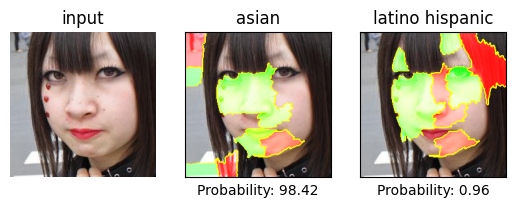

In [108]:
for i in range(100):
    image = np.array(images[i])
    prediction = predict(image)
    
    explainer = lime_image.LimeImageExplainer()
    
    explanation = explainer.explain_instance(image, 
                                                predict, # classification function
                                                top_labels=2, 
                                                hide_color=0, 
                                                num_samples=1000,
                                                random_seed=0)
    make_plot(i+1)

In [160]:
from deepface.models.demography import Emotion, Gender, Race

model_emotion = Emotion.load_model()
model_gender = Gender.load_model()
model_race = Race.load_model()

In [164]:
gender_predictions = model_gender.predict(np.array(images[0])[None,:])
race_predictions = model_race.predict(np.array(images[0])[None,:])
#emotion_predictions = model_emotion.predict(np.array(images[0])[None,:])

1/1 [==============================] - 0s 13ms/step


In [133]:
from deepface.modules import modeling

In [165]:
emotion_model = modeling.build_model(
                    task="facial_attribute", model_name="Emotion"
                )
emotion_predictions = emotion_model.predict(np.array(images[0])[None,:])
#print(emotion_predictions)

In [192]:
#FGSM attack adapted from https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

import tensorflow as tf

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model_gender(input_image)
        loss = loss_object(input_label, prediction)
        
        # Get the gradients of the loss w.r.t to the input image.
        gradient = tape.gradient(loss, input_image)
        # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)
        return signed_grad

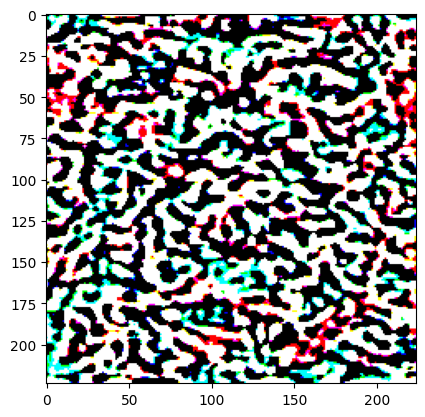

In [207]:
image = tf.convert_to_tensor(np.array(images[1])[None,:]) / 255
# Get the input label of the image.
index = 0
label = tf.one_hot(0, gender_predictions.shape[-1])
label = tf.reshape(label, (1, gender_predictions.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [208]:
def display_images(image, description, idx2label):
    prediction = np.array(model_gender.predict(image))
    confidence = np.max(prediction)
    label = idx2label[np.argmax(prediction)]
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.show()

1/1 [==============================] - 0s 14ms/step


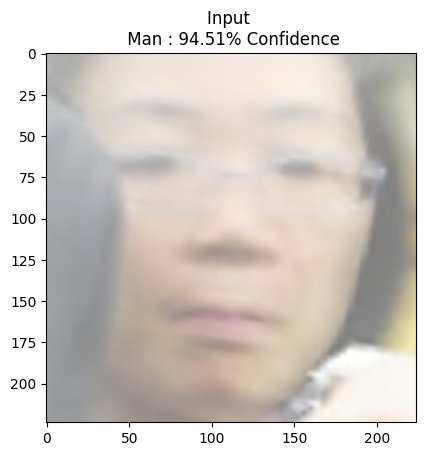

1/1 [==============================] - 0s 13ms/step


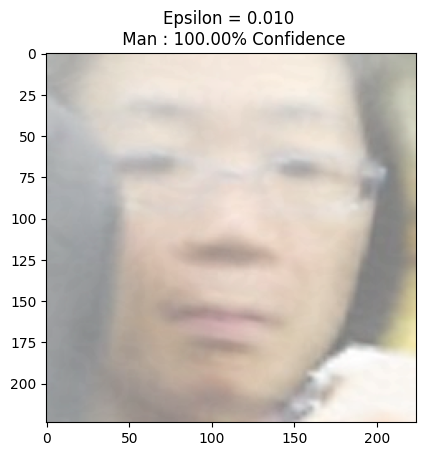

1/1 [==============================] - 0s 14ms/step


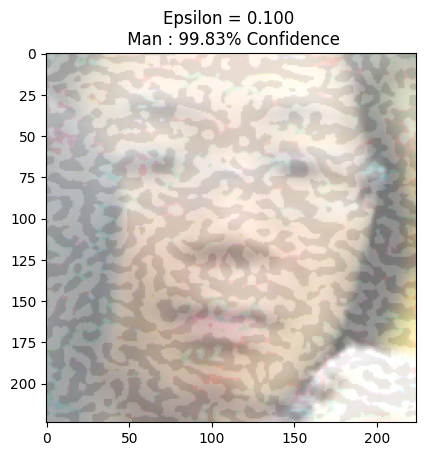

1/1 [==============================] - 0s 13ms/step


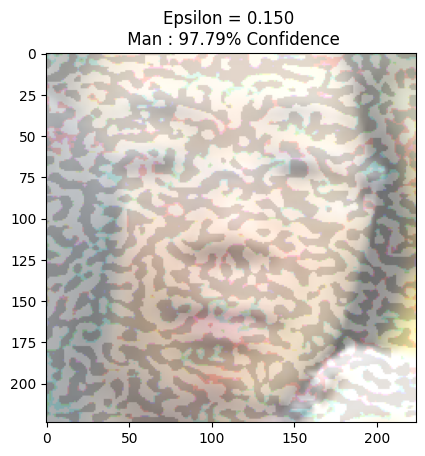

1/1 [==============================] - 0s 14ms/step


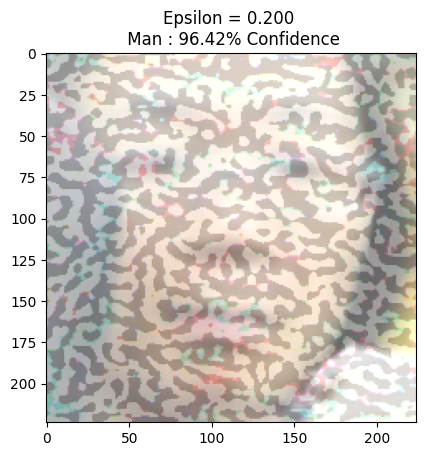

1/1 [==============================] - 0s 13ms/step


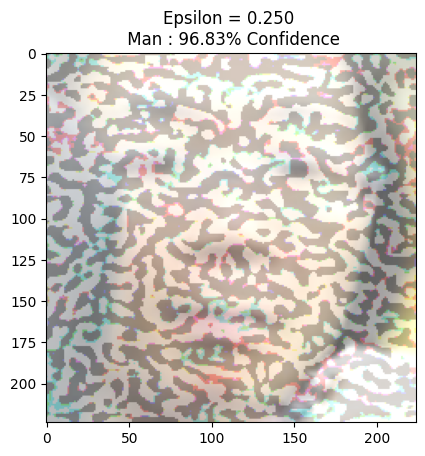

1/1 [==============================] - 0s 13ms/step


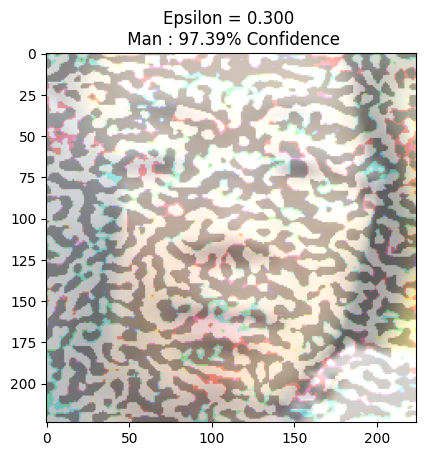

1/1 [==============================] - 0s 14ms/step


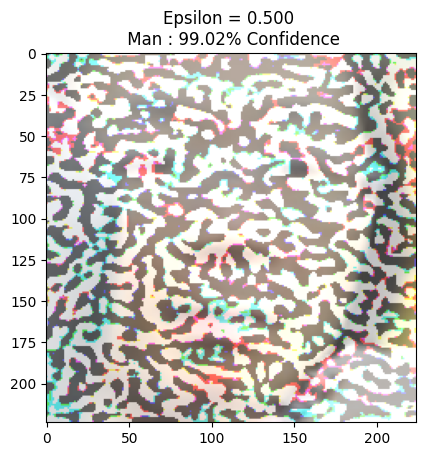

In [209]:
idx2label = ["Woman", "Man"]

epsilons = [0, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i], idx2label)